In [1]:
from google_play_scraper import app, Sort, reviews_all

import pandas as pd

import numpy as np

import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [2]:
# Read the CSV file into a DataFrame
df_tiktok = pd.read_csv('tiktok_reviews.csv')

C:\Users\USER\AppData\Local\Temp\ipykernel_18820\4044232992.py:2: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tiktok = pd.read_csv('tiktok_reviews.csv')


In [3]:
import pandas as pd

df_tiktok = pd.read_csv('tiktok_reviews.csv')
df_tiktok.to_excel('new_file.xlsx', index=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_18820\629938033.py:3: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tiktok = pd.read_csv('tiktok_reviews.csv')
c:\Users\USER\anaconda3\lib\site-packages\xlsxwriter\worksheet.py:1179: UserWarning: Ignoring URL 'https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  warn("Ignoring URL '%s' since it exceeds Excel's limit of "


In [4]:
# Convert data types of the columns
df_tiktok['reviewId'] = df_tiktok['reviewId'].astype(str)
df_tiktok['userName'] = df_tiktok['userName'].astype(str)
df_tiktok['userImage'] = df_tiktok['userImage'].astype(str)
df_tiktok['content'] = df_tiktok['content'].astype(str)
df_tiktok['score'] = df_tiktok['score'].astype(int)
df_tiktok['thumbsUpCount'] = df_tiktok['thumbsUpCount'].astype(int)
df_tiktok['reviewCreatedVersion'] = df_tiktok['reviewCreatedVersion'].astype(str)
df_tiktok['at'] = pd.to_datetime(df_tiktok['at'])
df_tiktok['replyContent'] = df_tiktok['replyContent'].astype(str)
df_tiktok['repliedAt'] = pd.to_datetime(df_tiktok['repliedAt'])


In [5]:
column_dtypes = df_tiktok.dtypes
print(column_dtypes)

reviewId                        object
userName                        object
userImage                       object
content                         object
score                            int32
thumbsUpCount                    int32
reviewCreatedVersion            object
at                      datetime64[ns]
replyContent                    object
repliedAt               datetime64[ns]
dtype: object


In [6]:
#Review Selection
# Convert 'at' column to datetime format
df_tiktok['at'] = pd.to_datetime(df_tiktok['at'])

# Set the start and end date range
start_date = pd.to_datetime('2022-05-23')
end_date = pd.to_datetime('2023-05-23')

# Filter the DataFrame for data within the specified date range
df_ytd = df_tiktok[(df_tiktok['at'] >= start_date) & (df_tiktok['at'] <= end_date)]

In [7]:
num_records = len(df_ytd)
print("Number of records in df_ytd:", num_records)

Number of records in df_ytd: 3051


In [8]:
start_date = df_ytd['at'].min()
end_date = df_ytd['at'].max()

print("Start Date:", start_date)
print("End Date:", end_date)


Start Date: 2022-05-23 01:07:01
End Date: 2023-05-22 22:21:17


In [9]:
df_textPreprocessing = df_ytd.copy()

In [10]:
#Manual Labelling

# Initialize the label column
df_textPreprocessing['label'] = None

# Iterate over each row in the DataFrame
for index, row in df_textPreprocessing.iterrows():
    review = row['content']
    rating = row['score']
    
    # Manually assign a label based on the rating
    if rating in [1, 2]:
        label = 'Negative'
    elif rating in [4, 5]:
        label = 'Positive'
    else:
        label = 'Neutral'
    
    # Update the 'label' column for the current row
    df_textPreprocessing.at[index, 'label'] = label


In [11]:
# Delete rows with "Neutral" label
df_textPreprocessing = df_textPreprocessing[df_textPreprocessing['label'] != 'Neutral']

# Remove neutral ratings
df_textPreprocessing = df_textPreprocessing[~df_textPreprocessing['score'].isin([3])]


In [12]:
df_textPreprocessing.head(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,label
4,f6bf5a42-271b-424a-a6a8-67f0d10c2960,sofiah said,https://play-lh.googleusercontent.com/a-/AD_cM...,Bagus lah pokoknya,5,0,29.5.5,2023-05-22 22:21:17,nan,NaT,Positive
5,bcd8a971-8dff-4dde-a742-088cc48db0e5,Budi Hermanto,https://play-lh.googleusercontent.com/a/AAcHTt...,Ok,5,0,29.5.5,2023-05-22 22:01:03,nan,NaT,Positive
6,9becbe97-2cf2-4820-afa2-e6b42e890f55,Alde Saputra,https://play-lh.googleusercontent.com/a-/AD_cM...,Tiktok ga bs di install padahal memo kosong,1,0,28.2.3,2023-05-22 19:02:25,nan,NaT,Negative
7,83cbef07-b58b-406a-bdf7-a7b4b1ba8674,Siti Aidah,https://play-lh.googleusercontent.com/a-/AD_cM...,"Kenapa tiktok sekarang gk bisa di buka, sasuh ...",4,0,nan,2023-05-22 18:54:57,nan,NaT,Positive
8,b77ad67f-6c12-4edf-aac2-64e1e013cf67,Areml Aremo,https://play-lh.googleusercontent.com/a/AAcHTt...,Susu,5,0,29.1.4,2023-05-22 18:53:44,nan,NaT,Positive
9,b0836733-e770-426f-b233-28d565def760,asri mekarwangi Jampank,https://play-lh.googleusercontent.com/a-/AD_cM...,Bagus tp terus minta di update,5,0,29.3.4,2023-05-22 18:42:27,nan,NaT,Positive
10,834a98e4-e86f-452e-a8f1-80fa20dc6d92,Hery Banjar,https://play-lh.googleusercontent.com/a/AAcHTt...,Mantap,5,0,nan,2023-05-22 18:23:57,nan,NaT,Positive
11,9165b562-d8ac-4708-9f49-51dceafa9339,Rini Suryani,https://play-lh.googleusercontent.com/a/AAcHTt...,Sangat bagus,5,0,29.3.4,2023-05-22 16:42:30,nan,NaT,Positive
12,59d98cc6-4687-4fec-9a65-07e9cc2f36a3,Estanislau Soares,https://play-lh.googleusercontent.com/a/AAcHTt...,Pass bnget temani pas lagi gabut,5,0,nan,2023-05-22 16:02:34,nan,NaT,Positive
13,8cf3f3aa-8afc-46d1-85eb-8fc5a65f7037,Babah Anom,https://play-lh.googleusercontent.com/a-/AD_cM...,Sangat menghibur,5,0,29.3.4,2023-05-22 15:18:13,nan,NaT,Positive


In [13]:
# Define the normalization mapping based on KBBI
normalization_mapping = {
    'di': 'di',
    'ini': 'ini',
    'dan': 'dan',
    'tok': 'tok',
    'nya': 'nya',
    'aku': 'aku',
    'Ok': 'bagus',
    'ada': 'ada',
    'tik': 'tik',
    'Aku': 'aku',
    'yg': 'yang',
    'Tik': 'TikTok',
    'gak': 'tidak',
    'ga': 'tidak',
    'ku': 'kamu',
    'the': 'the',
    'ya': 'ya',
    '5': 'lima',
    'aja': 'saja',
    'I': 'saya',
    'apk': 'aplikasi',
    '👍': 'bagus',
    'ke': 'ke',
    'mau': 'mau',
    'you': 'kamu',
    'kok': 'kok',
    'gk': 'tidak',
    'fyp': 'fyp',
    'sih': 'sih',
    'apa': 'apa',
    'Apk': 'aplikasi',
    'd': 'di',
    'app': 'aplikasi',
    'itu': 'itu',
    'ok': 'bagus',
    'lah': 'lah',
    'bgt': 'banget',
    'to': 'ke',
    '3': 'tiga',
    'is': 'adalah',
    'ko': 'kamu',
    'Ini': 'ini',
    'nia': 'nia',
    'and': 'dan',
    '2': 'dua',
    'hp': 'handphone',
    'kan': 'kan',
    'deh': 'deh',
    'Top': 'bagus',
    'gua': 'saya',
    'Oke': 'bagus',
    'my': 'saya',
    'i': 'saya',
    'ny': 'nya',
    'dgn': 'dengan',
    'Top.': 'bagus',
    'dagus': 'bagus',
    'bs': 'bisa',
    'senagsekali': 'senang sekali',
    'ferbaiki': 'perbaiki',
    'waifi': 'wifi',
    'The best': 'terbaik',
    'Mantab': 'mantap',
    'bgus': 'bagus',
    'Ko': 'kamu',
    'bgt': 'banget',
    'knp': 'kenapa',
    'jgn': 'jangan',
    'gtw': 'enggak tahu',
    'bsk': 'besok',
    'lgsg': 'langsung',
    'y': 'ya',
    'jg': 'juga',
    'tp': 'tapi',
    'trs': 'terus',
    'jd': 'jadi',
    'pdhl': 'padahal',
    'blm': 'belum',
    'dpt': 'dapat',
    'gk': 'gak',
    'bb': 'badan',
    'mgkn': 'mungkin',
    'sm': 'sama',
    'bngt': 'banget',
    'sgt': 'sangat',
    'gaul': 'keren',
    'cuy': 'bro',
    'mantap': 'bagus',
    'ngab': 'bro',
    'asem': 'asli semangat',
    'pake': 'pakai',
    'mabar': 'main bareng',
    'lahir batin': 'sepenuh hati',
    'tolol': 'bodoh',
    'baper': 'bawa perasaan',
    'wkwk': 'haha',
    'abis': 'habis',
    'wibu': 'penggemar budaya Jepang',
    'asyikkk': 'asyik',
    'baguus': 'bagus',
    'selaluih': 'selalu',
    'mmantap': 'mantap',
    'stabilo': 'stabil',
    'terbaikk': 'terbaik',
    'percumaa': 'percuma',
    'mahall': 'mahal',
    'manstap': 'mantap',
    'terbainya': 'terbaiknya',
    'malahh': 'malah',
    'tulusin': 'tuluskan',
    'gadaa': 'gak ada',
    'tok': 'tiktok',
    'menyedot': 'menghisap',
    'good': 'bagus'
    
}

# Function to perform manual normalization
def normalize_text(text):
    normalized_text = []
    words = text.split()
    for word in words:
        if word in normalization_mapping:
            normalized_word = normalization_mapping[word]
            normalized_text.append(normalized_word)
        else:
            normalized_text.append(word)
    normalized_text = ' '.join(normalized_text)
    return normalized_text

# Apply the text normalization function to the 'content' column
df_textPreprocessing['content'] = df_textPreprocessing['content'].apply(normalize_text)


In [14]:
df_textPreprocessing.head(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,label
4,f6bf5a42-271b-424a-a6a8-67f0d10c2960,sofiah said,https://play-lh.googleusercontent.com/a-/AD_cM...,Bagus lah pokoknya,5,0,29.5.5,2023-05-22 22:21:17,nan,NaT,Positive
5,bcd8a971-8dff-4dde-a742-088cc48db0e5,Budi Hermanto,https://play-lh.googleusercontent.com/a/AAcHTt...,bagus,5,0,29.5.5,2023-05-22 22:01:03,nan,NaT,Positive
6,9becbe97-2cf2-4820-afa2-e6b42e890f55,Alde Saputra,https://play-lh.googleusercontent.com/a-/AD_cM...,Tiktok tidak bisa di install padahal memo kosong,1,0,28.2.3,2023-05-22 19:02:25,nan,NaT,Negative
7,83cbef07-b58b-406a-bdf7-a7b4b1ba8674,Siti Aidah,https://play-lh.googleusercontent.com/a-/AD_cM...,"Kenapa tiktok sekarang gak bisa di buka, sasuh...",4,0,nan,2023-05-22 18:54:57,nan,NaT,Positive
8,b77ad67f-6c12-4edf-aac2-64e1e013cf67,Areml Aremo,https://play-lh.googleusercontent.com/a/AAcHTt...,Susu,5,0,29.1.4,2023-05-22 18:53:44,nan,NaT,Positive
9,b0836733-e770-426f-b233-28d565def760,asri mekarwangi Jampank,https://play-lh.googleusercontent.com/a-/AD_cM...,Bagus tapi terus minta di update,5,0,29.3.4,2023-05-22 18:42:27,nan,NaT,Positive
10,834a98e4-e86f-452e-a8f1-80fa20dc6d92,Hery Banjar,https://play-lh.googleusercontent.com/a/AAcHTt...,Mantap,5,0,nan,2023-05-22 18:23:57,nan,NaT,Positive
11,9165b562-d8ac-4708-9f49-51dceafa9339,Rini Suryani,https://play-lh.googleusercontent.com/a/AAcHTt...,Sangat bagus,5,0,29.3.4,2023-05-22 16:42:30,nan,NaT,Positive
12,59d98cc6-4687-4fec-9a65-07e9cc2f36a3,Estanislau Soares,https://play-lh.googleusercontent.com/a/AAcHTt...,Pass bnget temani pas lagi gabut,5,0,nan,2023-05-22 16:02:34,nan,NaT,Positive
13,8cf3f3aa-8afc-46d1-85eb-8fc5a65f7037,Babah Anom,https://play-lh.googleusercontent.com/a-/AD_cM...,Sangat menghibur,5,0,29.3.4,2023-05-22 15:18:13,nan,NaT,Positive


In [15]:
def case_folding(review):
    # Convert the review to lowercase
    folded_review = review.lower()
    return folded_review

df_textPreprocessing['folded_content'] = df_textPreprocessing['content'].apply(case_folding)

In [16]:
df_textPreprocessing.head(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,label,folded_content
4,f6bf5a42-271b-424a-a6a8-67f0d10c2960,sofiah said,https://play-lh.googleusercontent.com/a-/AD_cM...,Bagus lah pokoknya,5,0,29.5.5,2023-05-22 22:21:17,nan,NaT,Positive,bagus lah pokoknya
5,bcd8a971-8dff-4dde-a742-088cc48db0e5,Budi Hermanto,https://play-lh.googleusercontent.com/a/AAcHTt...,bagus,5,0,29.5.5,2023-05-22 22:01:03,nan,NaT,Positive,bagus
6,9becbe97-2cf2-4820-afa2-e6b42e890f55,Alde Saputra,https://play-lh.googleusercontent.com/a-/AD_cM...,Tiktok tidak bisa di install padahal memo kosong,1,0,28.2.3,2023-05-22 19:02:25,nan,NaT,Negative,tiktok tidak bisa di install padahal memo kosong
7,83cbef07-b58b-406a-bdf7-a7b4b1ba8674,Siti Aidah,https://play-lh.googleusercontent.com/a-/AD_cM...,"Kenapa tiktok sekarang gak bisa di buka, sasuh...",4,0,nan,2023-05-22 18:54:57,nan,NaT,Positive,"kenapa tiktok sekarang gak bisa di buka, sasuh..."
8,b77ad67f-6c12-4edf-aac2-64e1e013cf67,Areml Aremo,https://play-lh.googleusercontent.com/a/AAcHTt...,Susu,5,0,29.1.4,2023-05-22 18:53:44,nan,NaT,Positive,susu
9,b0836733-e770-426f-b233-28d565def760,asri mekarwangi Jampank,https://play-lh.googleusercontent.com/a-/AD_cM...,Bagus tapi terus minta di update,5,0,29.3.4,2023-05-22 18:42:27,nan,NaT,Positive,bagus tapi terus minta di update
10,834a98e4-e86f-452e-a8f1-80fa20dc6d92,Hery Banjar,https://play-lh.googleusercontent.com/a/AAcHTt...,Mantap,5,0,nan,2023-05-22 18:23:57,nan,NaT,Positive,mantap
11,9165b562-d8ac-4708-9f49-51dceafa9339,Rini Suryani,https://play-lh.googleusercontent.com/a/AAcHTt...,Sangat bagus,5,0,29.3.4,2023-05-22 16:42:30,nan,NaT,Positive,sangat bagus
12,59d98cc6-4687-4fec-9a65-07e9cc2f36a3,Estanislau Soares,https://play-lh.googleusercontent.com/a/AAcHTt...,Pass bnget temani pas lagi gabut,5,0,nan,2023-05-22 16:02:34,nan,NaT,Positive,pass bnget temani pas lagi gabut
13,8cf3f3aa-8afc-46d1-85eb-8fc5a65f7037,Babah Anom,https://play-lh.googleusercontent.com/a-/AD_cM...,Sangat menghibur,5,0,29.3.4,2023-05-22 15:18:13,nan,NaT,Positive,sangat menghibur


In [17]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stopword_remover = StopWordRemoverFactory().create_stop_word_remover()

df_textPreprocessing['content_without_stopwords'] = df_textPreprocessing['folded_content'].apply(stopword_remover.remove)

In [18]:
df_textPreprocessing.head(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,label,folded_content,content_without_stopwords
4,f6bf5a42-271b-424a-a6a8-67f0d10c2960,sofiah said,https://play-lh.googleusercontent.com/a-/AD_cM...,Bagus lah pokoknya,5,0,29.5.5,2023-05-22 22:21:17,nan,NaT,Positive,bagus lah pokoknya,bagus lah pokoknya
5,bcd8a971-8dff-4dde-a742-088cc48db0e5,Budi Hermanto,https://play-lh.googleusercontent.com/a/AAcHTt...,bagus,5,0,29.5.5,2023-05-22 22:01:03,nan,NaT,Positive,bagus,bagus
6,9becbe97-2cf2-4820-afa2-e6b42e890f55,Alde Saputra,https://play-lh.googleusercontent.com/a-/AD_cM...,Tiktok tidak bisa di install padahal memo kosong,1,0,28.2.3,2023-05-22 19:02:25,nan,NaT,Negative,tiktok tidak bisa di install padahal memo kosong,tiktok bisa install padahal memo kosong
7,83cbef07-b58b-406a-bdf7-a7b4b1ba8674,Siti Aidah,https://play-lh.googleusercontent.com/a-/AD_cM...,"Kenapa tiktok sekarang gak bisa di buka, sasuh...",4,0,nan,2023-05-22 18:54:57,nan,NaT,Positive,"kenapa tiktok sekarang gak bisa di buka, sasuh...","tiktok sekarang gak buka, sasuh mau buka tolon..."
8,b77ad67f-6c12-4edf-aac2-64e1e013cf67,Areml Aremo,https://play-lh.googleusercontent.com/a/AAcHTt...,Susu,5,0,29.1.4,2023-05-22 18:53:44,nan,NaT,Positive,susu,susu
9,b0836733-e770-426f-b233-28d565def760,asri mekarwangi Jampank,https://play-lh.googleusercontent.com/a-/AD_cM...,Bagus tapi terus minta di update,5,0,29.3.4,2023-05-22 18:42:27,nan,NaT,Positive,bagus tapi terus minta di update,bagus terus minta update
10,834a98e4-e86f-452e-a8f1-80fa20dc6d92,Hery Banjar,https://play-lh.googleusercontent.com/a/AAcHTt...,Mantap,5,0,nan,2023-05-22 18:23:57,nan,NaT,Positive,mantap,mantap
11,9165b562-d8ac-4708-9f49-51dceafa9339,Rini Suryani,https://play-lh.googleusercontent.com/a/AAcHTt...,Sangat bagus,5,0,29.3.4,2023-05-22 16:42:30,nan,NaT,Positive,sangat bagus,sangat bagus
12,59d98cc6-4687-4fec-9a65-07e9cc2f36a3,Estanislau Soares,https://play-lh.googleusercontent.com/a/AAcHTt...,Pass bnget temani pas lagi gabut,5,0,nan,2023-05-22 16:02:34,nan,NaT,Positive,pass bnget temani pas lagi gabut,pass bnget temani pas gabut
13,8cf3f3aa-8afc-46d1-85eb-8fc5a65f7037,Babah Anom,https://play-lh.googleusercontent.com/a-/AD_cM...,Sangat menghibur,5,0,29.3.4,2023-05-22 15:18:13,nan,NaT,Positive,sangat menghibur,sangat menghibur


In [19]:
def tokenize_text(review):
    # Tokenize the review into individual words
    tokens = nltk.word_tokenize(review)
    return tokens

df_textPreprocessing['tokens'] = df_textPreprocessing['content_without_stopwords'].apply(tokenize_text)

In [20]:
df_textPreprocessing.head(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,label,folded_content,content_without_stopwords,tokens
4,f6bf5a42-271b-424a-a6a8-67f0d10c2960,sofiah said,https://play-lh.googleusercontent.com/a-/AD_cM...,Bagus lah pokoknya,5,0,29.5.5,2023-05-22 22:21:17,nan,NaT,Positive,bagus lah pokoknya,bagus lah pokoknya,"[bagus, lah, pokoknya]"
5,bcd8a971-8dff-4dde-a742-088cc48db0e5,Budi Hermanto,https://play-lh.googleusercontent.com/a/AAcHTt...,bagus,5,0,29.5.5,2023-05-22 22:01:03,nan,NaT,Positive,bagus,bagus,[bagus]
6,9becbe97-2cf2-4820-afa2-e6b42e890f55,Alde Saputra,https://play-lh.googleusercontent.com/a-/AD_cM...,Tiktok tidak bisa di install padahal memo kosong,1,0,28.2.3,2023-05-22 19:02:25,nan,NaT,Negative,tiktok tidak bisa di install padahal memo kosong,tiktok bisa install padahal memo kosong,"[tiktok, bisa, install, padahal, memo, kosong]"
7,83cbef07-b58b-406a-bdf7-a7b4b1ba8674,Siti Aidah,https://play-lh.googleusercontent.com/a-/AD_cM...,"Kenapa tiktok sekarang gak bisa di buka, sasuh...",4,0,nan,2023-05-22 18:54:57,nan,NaT,Positive,"kenapa tiktok sekarang gak bisa di buka, sasuh...","tiktok sekarang gak buka, sasuh mau buka tolon...","[tiktok, sekarang, gak, buka, ,, sasuh, mau, b..."
8,b77ad67f-6c12-4edf-aac2-64e1e013cf67,Areml Aremo,https://play-lh.googleusercontent.com/a/AAcHTt...,Susu,5,0,29.1.4,2023-05-22 18:53:44,nan,NaT,Positive,susu,susu,[susu]
9,b0836733-e770-426f-b233-28d565def760,asri mekarwangi Jampank,https://play-lh.googleusercontent.com/a-/AD_cM...,Bagus tapi terus minta di update,5,0,29.3.4,2023-05-22 18:42:27,nan,NaT,Positive,bagus tapi terus minta di update,bagus terus minta update,"[bagus, terus, minta, update]"
10,834a98e4-e86f-452e-a8f1-80fa20dc6d92,Hery Banjar,https://play-lh.googleusercontent.com/a/AAcHTt...,Mantap,5,0,nan,2023-05-22 18:23:57,nan,NaT,Positive,mantap,mantap,[mantap]
11,9165b562-d8ac-4708-9f49-51dceafa9339,Rini Suryani,https://play-lh.googleusercontent.com/a/AAcHTt...,Sangat bagus,5,0,29.3.4,2023-05-22 16:42:30,nan,NaT,Positive,sangat bagus,sangat bagus,"[sangat, bagus]"
12,59d98cc6-4687-4fec-9a65-07e9cc2f36a3,Estanislau Soares,https://play-lh.googleusercontent.com/a/AAcHTt...,Pass bnget temani pas lagi gabut,5,0,nan,2023-05-22 16:02:34,nan,NaT,Positive,pass bnget temani pas lagi gabut,pass bnget temani pas gabut,"[pass, bnget, temani, pas, gabut]"
13,8cf3f3aa-8afc-46d1-85eb-8fc5a65f7037,Babah Anom,https://play-lh.googleusercontent.com/a-/AD_cM...,Sangat menghibur,5,0,29.3.4,2023-05-22 15:18:13,nan,NaT,Positive,sangat menghibur,sangat menghibur,"[sangat, menghibur]"


In [21]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Create an instance of the Sastrawi stemmer
stemmer = StemmerFactory().create_stemmer()

def stem_tokens(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_sentence = ' '.join(stemmed_tokens)  # Join tokens with whitespace separator
    return stemmed_sentence

df_textPreprocessing['stemmed_sentence'] = df_textPreprocessing['tokens'].apply(stem_tokens)

In [22]:
# Replace 'good' with 'bagus' in the 'stemmed_sentence' column
df_textPreprocessing['stemmed_sentence'] = df_textPreprocessing['stemmed_sentence'].str.replace('good', 'bagus')


In [23]:
# Remove 'nya' from the values in the 'stemmed_sentence' column
df_textPreprocessing['stemmed_sentence'] = df_textPreprocessing['stemmed_sentence'].str.replace('nya', '')

In [24]:
df_textPreprocessing.head(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,label,folded_content,content_without_stopwords,tokens,stemmed_sentence
4,f6bf5a42-271b-424a-a6a8-67f0d10c2960,sofiah said,https://play-lh.googleusercontent.com/a-/AD_cM...,Bagus lah pokoknya,5,0,29.5.5,2023-05-22 22:21:17,nan,NaT,Positive,bagus lah pokoknya,bagus lah pokoknya,"[bagus, lah, pokoknya]",bagus lah pokok
5,bcd8a971-8dff-4dde-a742-088cc48db0e5,Budi Hermanto,https://play-lh.googleusercontent.com/a/AAcHTt...,bagus,5,0,29.5.5,2023-05-22 22:01:03,nan,NaT,Positive,bagus,bagus,[bagus],bagus
6,9becbe97-2cf2-4820-afa2-e6b42e890f55,Alde Saputra,https://play-lh.googleusercontent.com/a-/AD_cM...,Tiktok tidak bisa di install padahal memo kosong,1,0,28.2.3,2023-05-22 19:02:25,nan,NaT,Negative,tiktok tidak bisa di install padahal memo kosong,tiktok bisa install padahal memo kosong,"[tiktok, bisa, install, padahal, memo, kosong]",tiktok bisa install padahal memo kosong
7,83cbef07-b58b-406a-bdf7-a7b4b1ba8674,Siti Aidah,https://play-lh.googleusercontent.com/a-/AD_cM...,"Kenapa tiktok sekarang gak bisa di buka, sasuh...",4,0,nan,2023-05-22 18:54:57,nan,NaT,Positive,"kenapa tiktok sekarang gak bisa di buka, sasuh...","tiktok sekarang gak buka, sasuh mau buka tolon...","[tiktok, sekarang, gak, buka, ,, sasuh, mau, b...",tiktok sekarang gak buka sasuh mau buka tolon...
8,b77ad67f-6c12-4edf-aac2-64e1e013cf67,Areml Aremo,https://play-lh.googleusercontent.com/a/AAcHTt...,Susu,5,0,29.1.4,2023-05-22 18:53:44,nan,NaT,Positive,susu,susu,[susu],susu
9,b0836733-e770-426f-b233-28d565def760,asri mekarwangi Jampank,https://play-lh.googleusercontent.com/a-/AD_cM...,Bagus tapi terus minta di update,5,0,29.3.4,2023-05-22 18:42:27,nan,NaT,Positive,bagus tapi terus minta di update,bagus terus minta update,"[bagus, terus, minta, update]",bagus terus minta update
10,834a98e4-e86f-452e-a8f1-80fa20dc6d92,Hery Banjar,https://play-lh.googleusercontent.com/a/AAcHTt...,Mantap,5,0,nan,2023-05-22 18:23:57,nan,NaT,Positive,mantap,mantap,[mantap],mantap
11,9165b562-d8ac-4708-9f49-51dceafa9339,Rini Suryani,https://play-lh.googleusercontent.com/a/AAcHTt...,Sangat bagus,5,0,29.3.4,2023-05-22 16:42:30,nan,NaT,Positive,sangat bagus,sangat bagus,"[sangat, bagus]",sangat bagus
12,59d98cc6-4687-4fec-9a65-07e9cc2f36a3,Estanislau Soares,https://play-lh.googleusercontent.com/a/AAcHTt...,Pass bnget temani pas lagi gabut,5,0,nan,2023-05-22 16:02:34,nan,NaT,Positive,pass bnget temani pas lagi gabut,pass bnget temani pas gabut,"[pass, bnget, temani, pas, gabut]",pass bnget teman pas gabut
13,8cf3f3aa-8afc-46d1-85eb-8fc5a65f7037,Babah Anom,https://play-lh.googleusercontent.com/a-/AD_cM...,Sangat menghibur,5,0,29.3.4,2023-05-22 15:18:13,nan,NaT,Positive,sangat menghibur,sangat menghibur,"[sangat, menghibur]",sangat hibur


In [25]:
df_featuresExtraction = df_textPreprocessing.copy()

In [26]:
X = df_featuresExtraction['stemmed_sentence'] #features
y = df_featuresExtraction['label'] #label

In [27]:
from sklearn.model_selection import train_test_split
#80:20 Ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer with desired n-gram range
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Fit the vectorizer on the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = vectorizer.transform(X_test)

In [29]:
#Sentiment Analysis Classification

In [30]:
from sklearn.naive_bayes import MultinomialNB
#Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_accuracy = nb_model.score(X_test_tfidf, y_test)

In [31]:
from sklearn.svm import SVC
#Support Vector Machine
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)
svm_accuracy = svm_model.score(X_test_tfidf, y_test)

In [32]:
from sklearn.ensemble import RandomForestClassifier
#Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
rf_accuracy = rf_model.score(X_test_tfidf, y_test)

In [33]:
# Naive Bayes
nb_accuracy = nb_model.score(X_test_tfidf, y_test)
print("Naive Bayes Accuracy:", nb_accuracy)

# Support Vector Machine (SVM)
svm_accuracy = svm_model.score(X_test_tfidf, y_test)
print("SVM Accuracy:", svm_accuracy)

# Random Forest
rf_accuracy = rf_model.score(X_test_tfidf, y_test)
print("Random Forest Accuracy:", rf_accuracy)

Naive Bayes Accuracy: 0.8754325259515571
SVM Accuracy: 0.8754325259515571
Random Forest Accuracy: 0.8788927335640139


In [34]:
total_records = len(df_featuresExtraction)
train_ratio = 0.8

num_train_records = int(total_records * train_ratio)
num_test_records = total_records - num_train_records

print("Number of train data records:", num_train_records)
print("Number of test data records:", num_test_records)

Number of train data records: 2310
Number of test data records: 578


In [35]:
from sklearn.metrics import confusion_matrix

# Make predictions on the test dataset using the Naive Bayes model
nb_y_pred = nb_model.predict(X_test_tfidf)

# Calculate the confusion matrix for Naive Bayes
nb_cm = confusion_matrix(y_test, nb_y_pred)

# Print the confusion matrix for Naive Bayes
print("Confusion matrix (Naive Bayes):")
print(nb_cm)


Confusion matrix (Naive Bayes):
[[  0  72]
 [  0 506]]


In [36]:
# Naive Bayes
nb_predicted = nb_model.predict(X_test_tfidf)
nb_report = classification_report(y_test, nb_predicted, zero_division=0)

print("Naive Bayes Classification Report:")
print(nb_report)

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        72
    Positive       0.88      1.00      0.93       506

    accuracy                           0.88       578
   macro avg       0.44      0.50      0.47       578
weighted avg       0.77      0.88      0.82       578



In [37]:
from sklearn.metrics import confusion_matrix

svm_predicted = svm_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, svm_predicted)

print("Confusion Matrix (SVM):")
print(cm)


Confusion Matrix (SVM):
[[  1  71]
 [  1 505]]


In [38]:
# Support Vector Machine (SVM)
svm_predicted = svm_model.predict(X_test_tfidf)
svm_report = classification_report(y_test, svm_predicted, zero_division=0)

print("SVM Classification Report:")
print(svm_report)

SVM Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      0.01      0.03        72
    Positive       0.88      1.00      0.93       506

    accuracy                           0.88       578
   macro avg       0.69      0.51      0.48       578
weighted avg       0.83      0.88      0.82       578



In [39]:
from sklearn.metrics import classification_report

rf_predicted = rf_model.predict(X_test_tfidf)
rf_report = classification_report(y_test, rf_predicted, zero_division=0)

print("Random Forest Classification Report:")
print(rf_report)

Random Forest Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.08      0.15        72
    Positive       0.88      0.99      0.93       506

    accuracy                           0.88       578
   macro avg       0.74      0.54      0.54       578
weighted avg       0.85      0.88      0.84       578



In [40]:
from sklearn.metrics import confusion_matrix

rf_cm = confusion_matrix(y_test, rf_predicted)

print("Confusion Matrix (Random Forest):")
print(rf_cm)

Confusion Matrix (Random Forest):
[[  6  66]
 [  4 502]]


In [41]:
from sklearn.metrics import classification_report

# Calculate the classification report for each model
nb_report = classification_report(y_test, nb_predicted, zero_division=0, output_dict=True)
svm_report = classification_report(y_test, svm_predicted, zero_division=0, output_dict=True)
rf_report = classification_report(y_test, rf_predicted, zero_division=0, output_dict=True)

# Extract the evaluation metrics
nb_precision = nb_report['weighted avg']['precision']
nb_recall = nb_report['weighted avg']['recall']
nb_f1_score = nb_report['weighted avg']['f1-score']
nb_accuracy = nb_report['accuracy']

svm_precision = svm_report['weighted avg']['precision']
svm_recall = svm_report['weighted avg']['recall']
svm_f1_score = svm_report['weighted avg']['f1-score']
svm_accuracy = svm_report['accuracy']

rf_precision = rf_report['weighted avg']['precision']
rf_recall = rf_report['weighted avg']['recall']
rf_f1_score = rf_report['weighted avg']['f1-score']
rf_accuracy = rf_report['accuracy']

# Print the comparison table
print("Comparison of Classification Model's Result")
print("Model\t\tPrecision\tRecall\t\tF-1 Score\tAccuracy")
print("Naive Bayes\t{:.3f}\t\t{:.3f}\t\t{:.3f}\t\t{:.3f}".format(nb_precision, nb_recall, nb_f1_score, nb_accuracy))
print("Support Vector Machine\t{:.3f}\t\t{:.3f}\t\t{:.3f}\t\t{:.3f}".format(svm_precision, svm_recall, svm_f1_score, svm_accuracy))
print("Random Forest\t{:.3f}\t\t{:.3f}\t\t{:.3f}\t\t{:.3f}".format(rf_precision, rf_recall, rf_f1_score, rf_accuracy))


Comparison of Classification Model's Result
Model		Precision	Recall		F-1 Score	Accuracy
Naive Bayes	0.766		0.875		0.817		0.875
Support Vector Machine	0.830		0.875		0.821		0.875
Random Forest	0.848		0.879		0.837		0.879


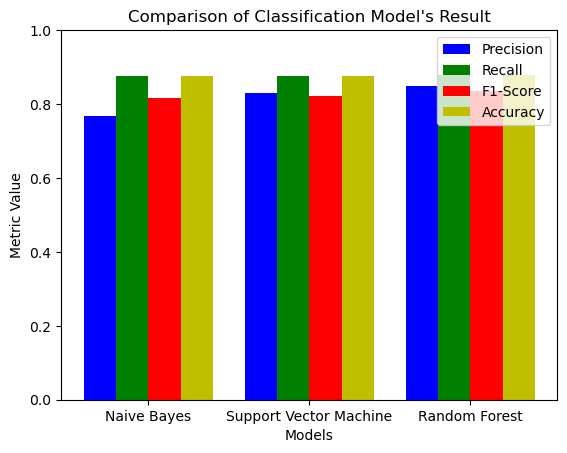

In [42]:
import matplotlib.pyplot as plt

# Define the models and their corresponding metric values
models = ['Naive Bayes', 'Support Vector Machine', 'Random Forest']
precision = [nb_precision, svm_precision, rf_precision]
recall = [nb_recall, svm_recall, rf_recall]
f1_score = [nb_f1_score, svm_f1_score, rf_f1_score]
accuracy = [nb_accuracy, svm_accuracy, rf_accuracy]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bar chart
plt.bar(r1, precision, color='b', width=bar_width, label='Precision')
plt.bar(r2, recall, color='g', width=bar_width, label='Recall')
plt.bar(r3, f1_score, color='r', width=bar_width, label='F1-Score')
plt.bar(r4, accuracy, color='y', width=bar_width, label='Accuracy')

# Add x-axis labels and title
plt.xlabel('Models')
plt.ylabel('Metric Value')
plt.title('Comparison of Classification Model\'s Result')

# Add y-axis range and tick labels
plt.ylim(0, 1)
plt.xticks([r + bar_width * 1.5 for r in range(len(models))], models)

# Add legend
plt.legend()

# Display the chart
plt.show()


In [43]:
from collections import Counter

# Filter the DataFrame for positive label records
positive_df = df_featuresExtraction[df_featuresExtraction['label'] == 'Positive']

# Concatenate all positive reviews into a single string
positive_reviews = ' '.join(positive_df['stemmed_sentence'])

# Tokenize the string into individual words
positive_tokens = nltk.word_tokenize(positive_reviews)

# Count the frequency of each word
word_freq = Counter(positive_tokens)

# Sort the word frequencies in descending order
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Number of top words to retrieve
top_n = 10

# Retrieve the top N words with the highest frequencies
top_words = sorted_word_freq[:top_n]

# Print the top words and their frequencies
for word, freq in top_words:
    print(word, freq)


bagus 912
tiktok 391
sangat 365
aplikasi 252
hibur 193
suka 167
aku 131
banget 120
baik 107
sekali 80


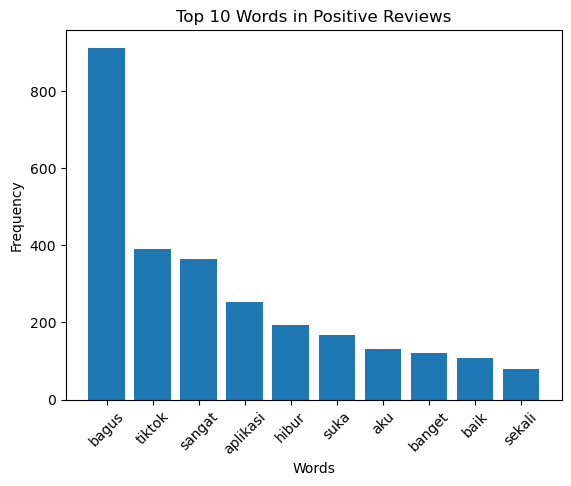

In [44]:
import matplotlib.pyplot as plt

# Retrieve the top N words and their frequencies
top_words = sorted_word_freq[:top_n]

# Extract the words and frequencies into separate lists
words = [word for word, freq in top_words]
frequencies = [freq for word, freq in top_words]

# Create a bar plot
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Words in Positive Reviews'.format(top_n))

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()


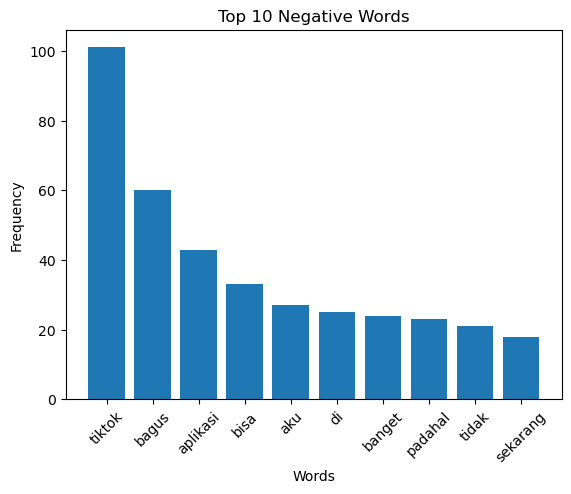

In [45]:
import matplotlib.pyplot as plt
from collections import Counter

# Filter the DataFrame for negative label records
negative_df = df_featuresExtraction[df_featuresExtraction['label'] == 'Negative']

# Concatenate all negative reviews into a single string
negative_reviews = ' '.join(negative_df['stemmed_sentence'])

# Tokenize the string into individual words
negative_tokens = nltk.word_tokenize(negative_reviews)

# Count the frequency of each word
word_freq = Counter(negative_tokens)

# Sort the word frequencies in descending order
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Retrieve the top 10 words with the highest frequencies
top_words = sorted_word_freq[:10]

# Extract the words and frequencies for plotting
words = [word for word, freq in top_words]
frequencies = [freq for word, freq in top_words]

# Create a bar chart
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Negative Words')
plt.xticks(rotation=45)
plt.show()


In [46]:
pip install wordcloud


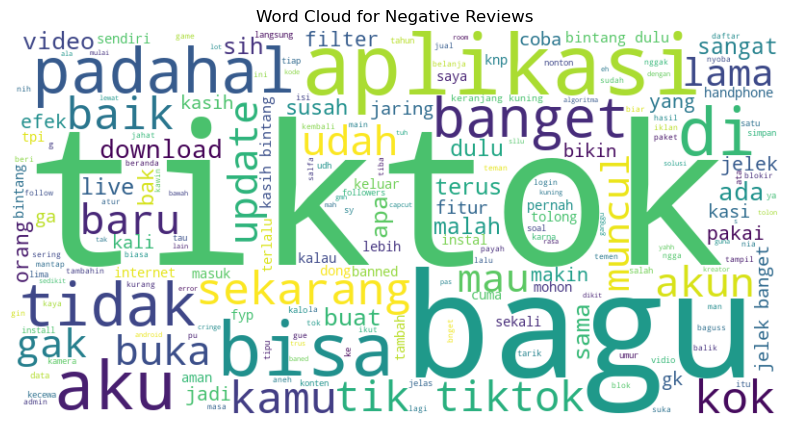

In [47]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame for negative label records
negative_df = df_featuresExtraction[df_featuresExtraction['label'] == 'Negative']

# Concatenate all negative reviews into a single string
negative_reviews = ' '.join(negative_df['stemmed_sentence'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


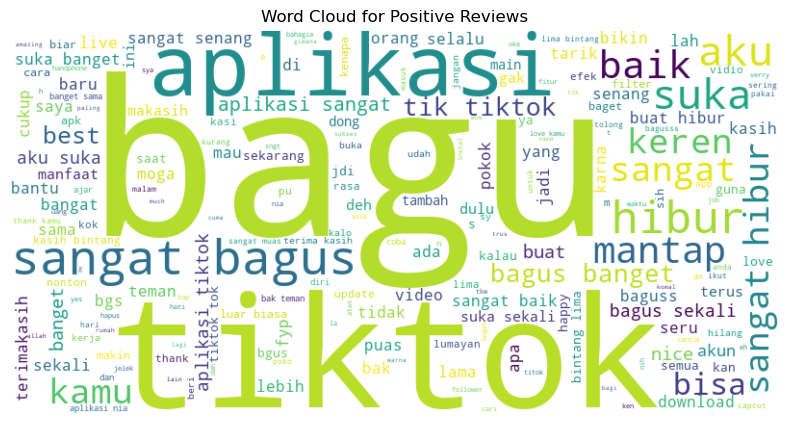

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame for positive label records
positive_df = df_featuresExtraction[df_featuresExtraction['label'] == 'Positive']

# Concatenate all positive reviews into a single string
positive_reviews = ' '.join(positive_df['stemmed_sentence'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()
